# GAN-based synthesis of rare diseases images

## Data preparation

In [1]:
import kagglehub

# Download latest version
data_dir = kagglehub.dataset_download("dibakarmalakar/pancreatic-tumor-dataset-2d")
data_dir

100%|██████████| 114M/114M [00:00<00:00, 137MB/s]

Extracting files...


'/root/.cache/kagglehub/datasets/dibakarmalakar/pancreatic-tumor-dataset-2d/versions/1'

In [2]:
!mv "{data_dir}" "./data"

In [3]:
image_dir = "data/Images/Images"
mask_dir = "data/Masks/Masks"

### Loading and Preprocessing

In [4]:
!pip install tensorflow-io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 17.9 MB/s eta 0:00:00


In [5]:
import tensorflow as tf
import tensorflow_io as tfio  # For .tiff support
import os

def preprocess_image(image_path, mask_path, target_size=(256, 256)):
    # Load image and mask
    image = tf.io.read_file(image_path)
    image = tfio.experimental.image.decode_tiff(image)
    mask = tf.io.read_file(mask_path)
    mask = tfio.experimental.image.decode_tiff(mask)

    # Select the first channel (if multi-channel images)
    image = image[..., :1]  # Keep only the first channel
    mask = mask[..., :1]    # Keep only the first channel

    # Resize to target size
    image = tf.image.resize(image, target_size)
    mask = tf.image.resize(mask, target_size)

    # Normalize
    image = image / 255.0  # Normalize to [0, 1]
    mask = mask / 255.0    # Normalize to [0, 1] for binary masks

    return image, mask

In [6]:
image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tiff')])
mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.tiff')])

assert len(image_paths) == len(mask_paths), "Mismatch between number of images and masks"

In [7]:
print(image_paths[:5])
print(mask_paths[:5])

['data/Images/Images/pancreas_001_ct_slice_0001.tiff', 'data/Images/Images/pancreas_001_ct_slice_0002.tiff', 'data/Images/Images/pancreas_001_ct_slice_0003.tiff', 'data/Images/Images/pancreas_001_ct_slice_0004.tiff', 'data/Images/Images/pancreas_001_ct_slice_0005.tiff']
['data/Masks/Masks/pancreas_001_label_slice_0001.tiff', 'data/Masks/Masks/pancreas_001_label_slice_0002.tiff', 'data/Masks/Masks/pancreas_001_label_slice_0003.tiff', 'data/Masks/Masks/pancreas_001_label_slice_0004.tiff', 'data/Masks/Masks/pancreas_001_label_slice_0005.tiff']


In [8]:
for img, mask in zip(image_paths, mask_paths):
    assert os.path.basename(img).replace("_ct_", "_label_") == os.path.basename(mask), f"Image and mask mismatch: {img}, {mask}"

In [9]:
def load_data(image_path, mask_path):
    # Convert to tf.string explicitly
    image_path = tf.cast(image_path, tf.string)
    mask_path = tf.cast(mask_path, tf.string)
    return preprocess_image(image_path, mask_path)

dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [10]:
for image_batch, mask_batch in dataset.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Mask batch shape: {mask_batch.shape}")

Image batch shape: (32, 256, 256, 1)
Mask batch shape: (32, 256, 256, 1)


### Data Augmentation

In [11]:
def augment(image, mask):
    # Random flip
    image = tf.image.random_flip_left_right(image)
    mask = tf.image.random_flip_left_right(mask)

    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32))
    mask = tf.image.rot90(mask, k=tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32))

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    return image, mask

In [12]:
augmented_dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
augmented_dataset = augmented_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model Architecture

In [13]:
import tensorflow as tf
from tensorflow.keras import layers

# Generator: U-Net Architecture
def build_generator(input_shape=(256, 256, 2), output_channels=2):
    inputs = layers.Input(shape=input_shape)

    # Encoder (Downsampling)
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    # Decoder (Upsampling)
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),   # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(
        output_channels, 4, strides=2,
        padding='same', kernel_initializer=initializer,
        activation='tanh'
    )  # (bs, 256, 256, 2)

    # Connect Encoder and Decoder
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    outputs = last(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Discriminator: PatchGAN
def build_discriminator(input_shape=(256, 256, 2), target_shape=(256, 256, 2)):
    initializer = tf.random_normal_initializer(0., 0.02)

    inputs = layers.Input(shape=input_shape, name='inputs')

    down1 = downsample(64, 4, apply_batchnorm=False)(inputs)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)
    down4 = downsample(512, 4)(down3)  # (bs, 16, 16, 512)

    zero_pad1 = layers.ZeroPadding2D()(down4)  # (bs, 18, 18, 512)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)  # (bs, 15, 15, 512)

    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 17, 17, 512)

    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (bs, 14, 14, 1)

    return tf.keras.Model(inputs=inputs, outputs=last)

# Downsample Block
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(
            filters, size, strides=2, padding='same',
            kernel_initializer=initializer, use_bias=False
        )
    )
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())

    return result

# Upsample Block
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(
            filters, size, strides=2, padding='same',
            kernel_initializer=initializer, use_bias=False
        )
    )
    result.add(layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result


### Loss Functions

In [24]:
def weighted_binary_crossentropy(y_true, y_pred, weights):
    """
    Weighted BCE Loss function with dynamic weights.
    Args:
        y_true: Ground truth labels (binary mask, 0 or 1).
        y_pred: Predicted logits (before activation).
        weights: Tuple of (background_weight, foreground_weight).
    Returns:
        Weighted BCE loss.
    """
    background_weight, foreground_weight = weights
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    bce = -(
        foreground_weight * y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-7, 1.0)) +
        background_weight * (1 - y_true) * tf.math.log(tf.clip_by_value(1 - y_pred, 1e-7, 1.0))
    )
    return tf.reduce_mean(bce)


In [25]:
def discriminator_loss(real_output, fake_output, masks):
    # Compute dynamic weights based on masks
    weights = compute_class_weights(masks)
    real_loss = weighted_binary_crossentropy(
        tf.ones_like(real_output), real_output, weights
    )
    fake_loss = weighted_binary_crossentropy(
        tf.zeros_like(fake_output), fake_output, weights
    )
    return real_loss + fake_loss


In [26]:
def generator_loss(fake_output, gen_output, target, masks, lambda_l1=100):
    # Compute dynamic weights based on masks
    weights = compute_class_weights(masks)
    adversarial_loss = weighted_binary_crossentropy(
        tf.ones_like(fake_output), fake_output, weights
    )
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))  # L1 Loss
    return adversarial_loss + (lambda_l1 * l1_loss)


In [27]:
tf.config.run_functions_eagerly(True)

def compute_class_weights(masks):
    """
    Calculate class weights for the dataset or batch based on pixel values.
    Args:
        masks: Ground truth masks with values 0 and 1.
    Returns:
        Tuple of (background_weight, foreground_weight).
    """
    total_pixels = tf.cast(tf.size(masks), tf.float32)
    foreground_pixels = tf.reduce_sum(masks)

    # print(f"Total pixels type: {total_pixels.dtype}, Foreground pixels type: {foreground_pixels.dtype}")
    background_pixels = total_pixels - foreground_pixels

    background_weight = foreground_pixels / total_pixels
    foreground_weight = background_pixels / total_pixels

    # Ensure we compute values before converting to numpy
    background_weight_value = background_weight.numpy()
    foreground_weight_value = foreground_weight.numpy()

    return background_weight_value, foreground_weight_value


### Training

In [28]:
@tf.function
def train_step(input_image, target_image, generator, discriminator,
               generator_optimizer, discriminator_optimizer):
    # Concatenate image and mask for generator input
    generator_input = tf.concat([input_image, target_image], axis=-1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generator forward pass
        gen_output = generator(generator_input, training=True)
        gen_mask = gen_output[:, :, :, 1]
        gen_mask = tf.expand_dims(gen_mask, axis=-1)

        # print("cmon", gen_mask.shape)

        # Concatenate input image and generated/real masks for discriminator
        real_input = tf.concat([input_image, target_image], axis=-1)
        fake_input = tf.concat([input_image, gen_mask], axis=-1)

        # print(f"Input Image Shape: {input_image.shape}")  # Should be (batch_size, 256, 256, 1)
        # print(f"Target Image Shape: {target_image.shape}")  # Should be (batch_size, 256, 256, 1)
        # print(f"Generator Output Shape: {gen_output.shape}")  # Should be (batch_size, 256, 256, 1)
        # print(f"Real Input Shape: {real_input.shape}")  # Should be (batch_size, 256, 256, 2)
        # print(f"Fake Input Shape: {fake_input.shape}")  # Should be (batch_size, 256, 256, 2)


        # Discriminator forward pass
        real_output = discriminator(real_input, training=True)
        fake_output = discriminator(fake_input, training=True)

        # Compute losses
        gen_loss = generator_loss(fake_output, gen_output, target_image, target_image)
        disc_loss = discriminator_loss(real_output, fake_output, target_image)

    # Apply gradients
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [29]:
import time
import tensorflow as tf
from tqdm import tqdm

def train(dataset, generator, discriminator, generator_optimizer, discriminator_optimizer, epochs, log_interval=100):
    for epoch in range(epochs):
        start = time.time()

        print(f"Epoch {epoch+1}/{epochs}")
        progress_bar = tqdm(dataset, desc=f'Epoch {epoch+1}', position=0, leave=True)

        for step, (input_image, target_image) in enumerate(progress_bar):
            gen_loss, disc_loss = train_step(
                input_image, target_image, generator, discriminator,
                generator_optimizer, discriminator_optimizer
            )

            if step % log_interval == 0:
                progress_bar.set_postfix(GenLoss=f"{gen_loss.numpy():.4f}", DiscLoss=f"{disc_loss.numpy():.4f}")

        progress_bar.close()
        print(f"Epoch {epoch+1} completed in {time.time() - start:.2f}s")


In [34]:
# Example configuration
epochs = 25
log_interval = 10

# Initialize models and optimizers
generator = build_generator()  # Replace with your generator function
discriminator = build_discriminator()  # Replace with your discriminator function
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [31]:
generator.summary()

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20            │ (None, 256, 256, 2)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_19             │ (None, 128, 128, 64)   │          2,048 │ input_layer_20[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_20             │ (None, 64, 64, 128)    │        131,584 │ sequential_19[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_21             │ (None, 32, 32, 256)    │        525,312 │ sequential_20[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_22             │ (None, 16, 16, 512)    │      2,099,200 │ sequential_21[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_23             │ (None, 8, 8, 512)      │      4,196,352 │ sequential_22[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_24             │ (None, 4, 4, 512)      │      4,196,352 │ sequential_23[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_25             │ (None, 2, 2, 512)      │      4,196,352 │ sequential_24[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_26             │ (None, 1, 1, 512)      │      4,196,352 │ sequential_25[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_27             │ (None, 2, 2, 512)      │      4,196,352 │ sequential_26[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 2, 2, 1024)     │              0 │ sequential_27[0][0],   │
│ (Concatenate)             │                        │                │ sequential_25[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_28             │ (None, 4, 4, 512)      │      8,390,656 │ concatenate_7[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 4, 4, 1024)     │              0 │ sequential_28[0][0],   │
│ (Concatenate)             │                        │                │ sequential_24[0][0]    │
├──────────────────────

 Total params: 54,422,786 (207.61 MB)

 Trainable params: 54,411,906 (207.56 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [32]:
discriminator.summary()

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)                  │ (None, 256, 256, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_34 (Sequential)           │ (None, 128, 128, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_35 (Sequential)           │ (None, 64, 64, 128)         │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_36 (Sequential)           │ (None, 32, 32, 256)         │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_37 (Sequential)           │ (None, 16, 16, 512)         │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_2 (ZeroPadding2D)     │ (None, 18, 18, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 15, 15, 512)         │       4,194,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 15, 15, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_25 (LeakyReLU)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_3 (ZeroPadding2D)     │ (None, 17, 17, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 14, 14, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,962,689 (26.56 MB)

 Trainable params: 6,959,873 (26.55 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [35]:
# Train the model
train(dataset, generator, discriminator, generator_optimizer, discriminator_optimizer, epochs, log_interval)

Epoch 1/25


Epoch 1: 100%|██████████| 275/275 [08:21<00:00,  1.83s/it, DiscLoss=0.0186, GenLoss=0.8390]


Epoch 1 completed in 501.92s
Epoch 2/25


Epoch 2: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0203, GenLoss=0.5646]


Epoch 2 completed in 441.93s
Epoch 3/25


Epoch 3: 100%|██████████| 275/275 [07:16<00:00,  1.59s/it, DiscLoss=0.0125, GenLoss=0.5142]


Epoch 3 completed in 436.45s
Epoch 4/25


Epoch 4: 100%|██████████| 275/275 [07:14<00:00,  1.58s/it, DiscLoss=0.0066, GenLoss=0.4265]


Epoch 4 completed in 434.94s
Epoch 5/25


Epoch 5: 100%|██████████| 275/275 [07:13<00:00,  1.57s/it, DiscLoss=0.0060, GenLoss=0.2406]


Epoch 5 completed in 433.13s
Epoch 6/25


Epoch 6: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0059, GenLoss=0.0985]


Epoch 6 completed in 441.93s
Epoch 7/25


Epoch 7: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0058, GenLoss=0.0628]


Epoch 7 completed in 441.93s
Epoch 8/25


Epoch 8: 100%|██████████| 275/275 [07:10<00:00,  1.57s/it, DiscLoss=0.0058, GenLoss=0.0561]


Epoch 8 completed in 430.50s
Epoch 9/25


Epoch 9: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0057, GenLoss=0.0466]


Epoch 9 completed in 441.92s
Epoch 10/25


Epoch 10: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0057, GenLoss=0.0342]


Epoch 10 completed in 441.94s
Epoch 11/25


Epoch 11: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0057, GenLoss=0.0300]


Epoch 11 completed in 441.92s
Epoch 12/25


Epoch 12: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0057, GenLoss=0.0237]


Epoch 12 completed in 441.92s
Epoch 13/25


Epoch 13: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0057, GenLoss=0.0222]


Epoch 13 completed in 441.92s
Epoch 14/25


Epoch 14: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0057, GenLoss=0.0241]


Epoch 14 completed in 441.93s
Epoch 15/25


Epoch 15: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0057, GenLoss=0.0261]


Epoch 15 completed in 441.93s
Epoch 16/25


Epoch 16: 100%|██████████| 275/275 [07:11<00:00,  1.57s/it, DiscLoss=0.0057, GenLoss=0.0305]


Epoch 16 completed in 431.50s
Epoch 17/25


Epoch 17: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0057, GenLoss=0.0279]


Epoch 17 completed in 441.92s
Epoch 18/25


Epoch 18: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0057, GenLoss=0.0199]


Epoch 18 completed in 441.92s
Epoch 19/25


Epoch 19: 100%|██████████| 275/275 [07:08<00:00,  1.56s/it, DiscLoss=0.0057, GenLoss=0.0295]


Epoch 19 completed in 428.75s
Epoch 20/25


Epoch 20: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0057, GenLoss=0.0225]


Epoch 20 completed in 441.93s
Epoch 21/25


Epoch 21: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0057, GenLoss=0.0187]


Epoch 21 completed in 441.93s
Epoch 22/25


Epoch 22: 100%|██████████| 275/275 [07:08<00:00,  1.56s/it, DiscLoss=0.0057, GenLoss=0.0203]


Epoch 22 completed in 428.61s
Epoch 23/25


Epoch 23: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0057, GenLoss=0.0207]


Epoch 23 completed in 441.92s
Epoch 24/25


Epoch 24: 100%|██████████| 275/275 [07:21<00:00,  1.61s/it, DiscLoss=0.0057, GenLoss=0.0147]


Epoch 24 completed in 441.93s
Epoch 25/25


Epoch 25: 100%|██████████| 275/275 [07:07<00:00,  1.55s/it, DiscLoss=0.0057, GenLoss=0.0156]

Epoch 25 completed in 427.38s


### Saving the Model

In [36]:
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')

## Inference

In [37]:
import numpy as np

# Generate 5 random inputs for inference
# Assuming inputs are normalized in the range [-1, 1]
input_images = np.random.uniform(-1, 1, (5, 256, 256, 1))  # Random CT scans
input_masks = np.random.uniform(-1, 1, (5, 256, 256, 1))   # Random masks

# Concatenate images and masks along the channel axis
input_data = np.concatenate([input_images, input_masks], axis=-1)  # Shape: (5, 256, 256, 2)

In [38]:
# Generate synthetic outputs
generated_outputs = generator.predict(input_data)

# Separate the generated images and masks
generated_images = generated_outputs[..., 0]  # Extract the first channel (generated CT scans)
generated_masks = generated_outputs[..., 1]  # Extract the second channel (generated masks)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


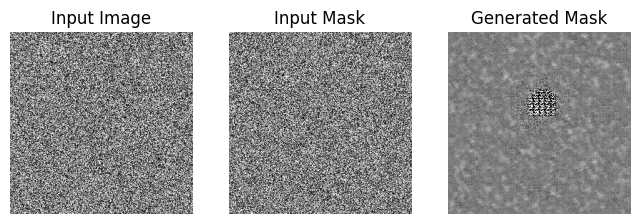

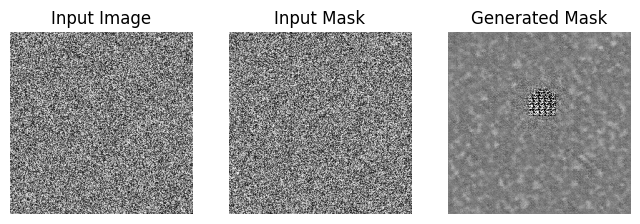

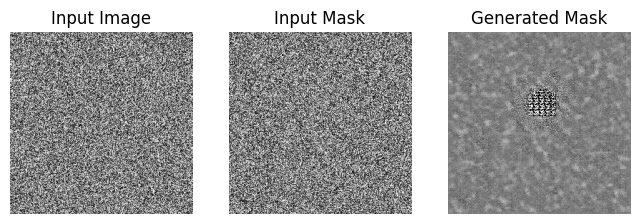

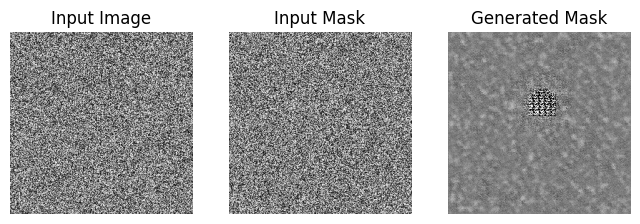

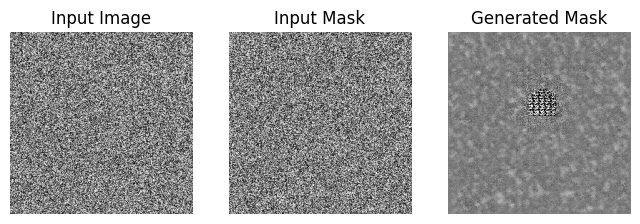

In [39]:
import matplotlib.pyplot as plt

# Visualize the results
for i in range(5):
    plt.figure(figsize=(8, 4))

    # Input image
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(input_data[i, ..., 0], cmap='gray')
    plt.axis('off')

    # Input mask
    plt.subplot(1, 3, 2)
    plt.title("Input Mask")
    plt.imshow(input_data[i, ..., 1], cmap='gray')
    plt.axis('off')

    # Generated output (image or mask)
    plt.subplot(1, 3, 3)
    plt.title("Generated Mask")
    plt.imshow(generated_masks[i], cmap='gray')
    plt.axis('off')

    plt.show()